In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
T_w = 80.0 + 273.0 # Temperatura de la pared [K]
T_a = 20.0 + 273.0 # Temperatura ambiente [K]
delta_T = T_w - T_a
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]
Ra_D = (g * beta * delta_T * (2 * R)**3)/ nu**2 # Numero de Rayleigh
Nu = (576/(Ra_D * 2 * R /L)**2 + 2.873/(Ra_D * 2 * R /L)**(1/2))**(-1/2)# Numero de Nusselt
h_v = (k * Nu)/ (2 * R * L) # coeficiente de tranferencia de calor por convección [W/(m^3 K)]

In [2]:
def f(u, A, B):
    return u - A * (1 - np.exp(-B/u))

def df(u, A, B):
    return 1 + A * (B/u**2) * np.exp(-B/u)

def newton_raphson(A, B, u0, tol, max_iter):
    u = u0
    for i in range(max_iter):
        f_val = f(u, A, B)
        df_val = df(u, A, B)
        u_new = u - f_val / df_val
        if np.abs(u_new - u) < tol:
            return u_new
        u = u_new
    return u

A = rho_0 * Cp * g * beta * (T_w - T_a) / (h_v * (0.5 + lambda_f * L /(8 * R)))
B = h_v * L / (rho_0 * Cp)
u0 = 0.01
tol = 1e-6
max_iter = 100

u_sol = newton_raphson(A, B, u0, tol, max_iter)
u_e = u_sol
print('u_e = ' + str(round(u_e,4))+ ' m/s')
gamma = h_v * L / (rho_0 * Cp * u_e)
T_f = T_a + (T_w - T_a) * (1 - np.exp(-gamma))
print('T_f = ' + str(T_f))
p_e = p_atm + 0.5 * rho_0 * u_e**2
print('p_e = ' + str(p_e))

u_e = 19.4829 m/s
T_f = 296.86366876093643
p_e = 101514.79171975271


## Adimensionalización: Opción 1, Pi = p / p_e

In [3]:
# Definimos el tiempo característico que vamos a usar, en principio t_c = L/ u_e:
t_c = L/ u_e 

# Defnimos las variables adimensionales de las ecuaciones:
Pi_d = rho_0 * u_e**2 / (2 * p_e)
Pi_0 = rho_0 * g * L / p_e
p_0 = p_atm / p_e
theta_r = (T_w - T_a) / (T_f - T_a)
Pi_prima = t_c * p_e / ( rho_0 * u_e * L)
phi = t_c * g * beta * (T_f - T_a) / u_e
LAMBDA = t_c * lambda_f * u_e / ( 8 * R)
psi = u_e * t_c / L
delta = t_c * alpha / L**2
gamma_prima = u_e * t_c * gamma / L

print('Pi_0 = ' + str(Pi_0) 
      + '\nPi_d = ' + str(Pi_d)
      + '\np_0 = ' + str(p_0)
      + '\ntheta_r = ' + str(theta_r)
      + '\nPi_prima = ' + str(Pi_prima)
      + '\nphi = ' + str(phi)
      + '\nLAMBDA = ' + str(LAMBDA)
      + '\npsi = ' + str(psi)
      + '\ndelta = ' + str(delta)
      + '\ngamma_prima = ' + str(gamma_prima)
      )

Pi_0 = 0.009653765558672886
Pi_d = 0.001869596701499989
p_0 = 0.9981304032985
theta_r = 15.529281548829731
Pi_prima = 267.43735672984815
phi = 0.03660873900002084
LAMBDA = 0.05
psi = 1.0
delta = 1.1291952756117161e-08
gamma_prima = 0.06656134363640165


## Simulación

In [4]:
# Definición de variables y condiciones iniciales
M = 256 # Número de puntos en la dirección vertical
N = 512 # Número de puntos en la dirección temporal
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/M
dtau = (tau[-1] - tau[0])/N 
v = np.zeros(N)  # Velocidad adimensional
theta = np.zeros((M, N))  # Temperatura adimensional
Pi = np.ones((M, N)) * p_0  # Presión adimensional, inicialmente todo el espacio se encuentra a p_atm

# Condiciones iniciales
v[0] = 0.0  # Velocidad inicial cero
theta[:, 0] = 0.0  # Temperatura inicial uniforme

# Simulación numérica
for t in range(1, N-1):

    # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
    v[t] = np.sqrt((Pi[0, t-1] - p_0) * Pi_d)

    # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
    for x in range(M-1):
         
        dtheta_deta = (theta[x+1, t-1] - theta[x, t-1]) / deta
        d2theta_deta2 = (theta[x+1, t-1] - 2 * theta[x, t-1] + theta[x-1, t-1]) / deta**2
        theta[x, t] = theta[x, t-1] + dtau * (- psi * v[t] * dtheta_deta
                                            + delta * d2theta_deta2
                                            - gamma_prima * (theta[x, t-1] - theta_r))
        
        dv_dt = (v[t] - v[t-1]) / dtau
        Pi[M-2-x, t] = Pi[M-1-x, t-1] + (deta / Pi_prima) * (dv_dt + phi * (theta[M-1-x, t] - theta_r) + LAMBDA * v[t]**2)  

/var/folders/lx/vhxvbgp94fj63r8wrldf_13m0000gn/T/ipykernel_2416/578767246.py:20: RuntimeWarning: invalid value encountered in sqrt
  v[t] = np.sqrt((Pi[0, t-1] - p_0) * Pi_d)


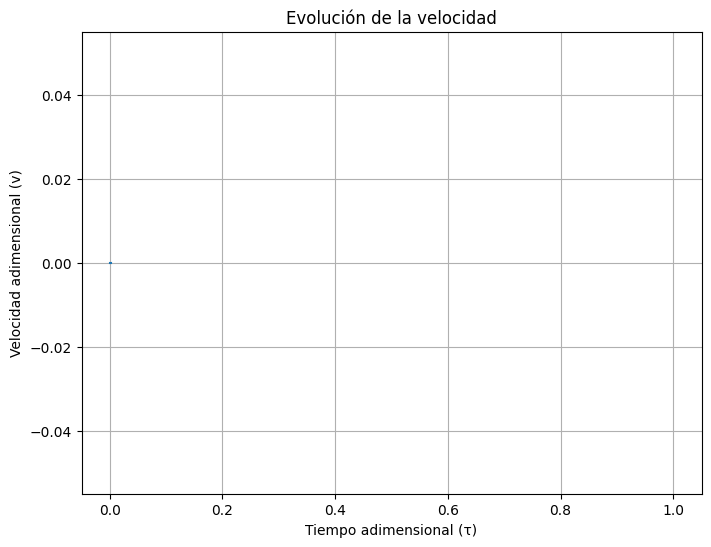

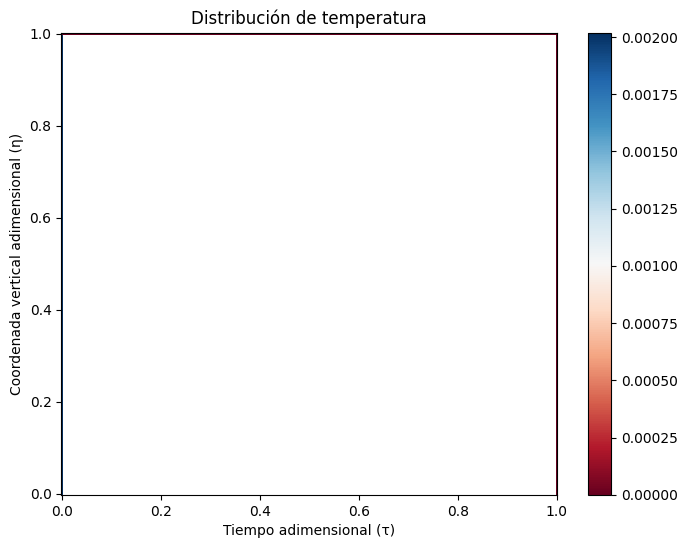

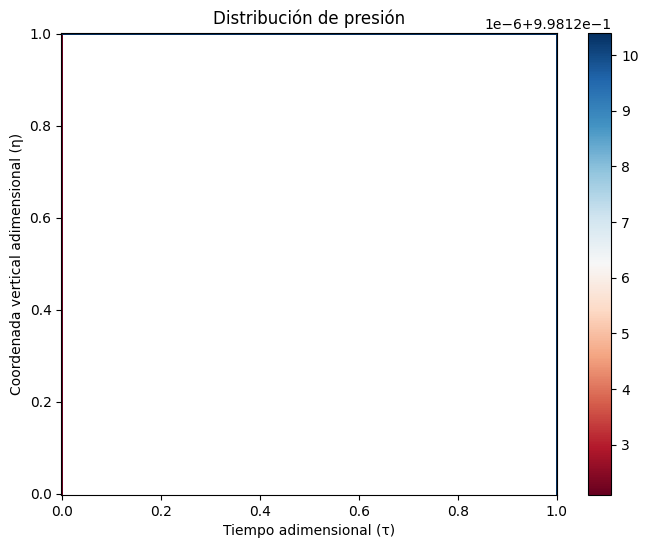

In [5]:
# Gráfico lineal de v
plt.figure(figsize=(8, 6))
plt.plot(tau, v)
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Velocidad adimensional (v)')
plt.title('Evolución de la velocidad')
plt.grid()
plt.show()

# Mapa de calor de θ
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, theta, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de temperatura')
plt.show()

# Mapa de calor de Π
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, Pi, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de presión')
plt.show()

## Adimensionalizacón: Opción 2, Pi = p / p_atm

In [6]:
# Definimos el tiempo característico que vamos a usar, en principio t_c = L/ u_e:
t_c = L/ u_e 

# Defnimos las variables adimensionales de las ecuaciones:
Pi_d = rho_0 * u_e**2 / p_atm
Pi_0 = rho_0 * g * L / p_atm
theta_r = (T_w - T_a) / (T_f - T_a)
Pi_prima = t_c * p_atm / ( rho_0 * u_e * L)
phi = t_c * g * beta * (T_f - T_a) / u_e
LAMBDA = t_c * lambda_f * u_e / ( 8 * R)
psi = u_e * t_c / L
delta = t_c * alpha / L**2
gamma_prima = u_e * t_c * gamma / L

print('Pi_0 = ' + str(Pi_0) 
      + '\nPi_d = ' + str(Pi_d)
      + '\ntheta_r = ' + str(theta_r)
      + '\nPi_prima = ' + str(Pi_prima)
      + '\nphi = ' + str(phi)
      + '\nLAMBDA = ' + str(LAMBDA)
      + '\npsi = ' + str(psi)
      + '\ndelta = ' + str(delta)
      + '\ngamma_prima = ' + str(gamma_prima)
      )

Pi_0 = 0.009671848013816927
Pi_d = 0.0037461972810798536
theta_r = 15.529281548829731
Pi_prima = 266.9373567298481
phi = 0.03660873900002084
LAMBDA = 0.05
psi = 1.0
delta = 1.1291952756117161e-08
gamma_prima = 0.06656134363640165


In [7]:
# Definición de variables y condiciones iniciales
M = 256 # Número de puntos en la dirección vertical
N = 512 # Número de puntos en la dirección temporal
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/M
dtau = (tau[-1] - tau[0])/N 
v = np.zeros(N)  # Velocidad adimensional
theta = np.zeros((M, N))  # Temperatura adimensional
Pi = np.ones((M, N))  # Presión adimensional, inicialmente todo el espacio se encuentra a p_atm

# Condiciones iniciales
v[0] = 0.0  # Velocidad inicial cero
theta[:, 0] = 0.0  # Temperatura inicial uniforme

# Simulación numérica
for t in range(1, N-1):

    # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
    v[t] = np.sqrt((Pi[0, t-1] - 1) * Pi_d)

    # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
    for x in range(M-1):
         
        dtheta_deta = (theta[x+1, t-1] - theta[x, t-1]) / deta
        d2theta_deta2 = (theta[x+1, t-1] - 2 * theta[x, t-1] + theta[x-1, t-1]) / deta**2
        theta[x, t] = theta[x, t-1] + dtau * (- psi * v[t] * dtheta_deta
                                            + delta * d2theta_deta2
                                            - gamma_prima * (theta[x, t-1] - theta_r))
        
        dv_dt = (v[t] - v[t-1]) / dtau
        Pi[M-2-x, t] = Pi[M-1-x, t-1] - (deta / Pi_prima) * (dv_dt + phi * (theta[M-1-x, t] - theta_r) + LAMBDA * v[t]**2)  

[[1.         1.00000832 1.00001531 ... 1.00206189 1.0020618  1.        ]
 [1.         1.00000832 1.00001531 ... 1.00205402 1.00205393 1.        ]
 [1.         1.00000832 1.00001531 ... 1.00204614 1.00204602 1.        ]
 ...
 [1.         1.00000832 1.00001532 ... 1.00001664 1.00001664 1.        ]
 [1.         1.00000832 1.000007   ... 1.00000832 1.00000832 1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


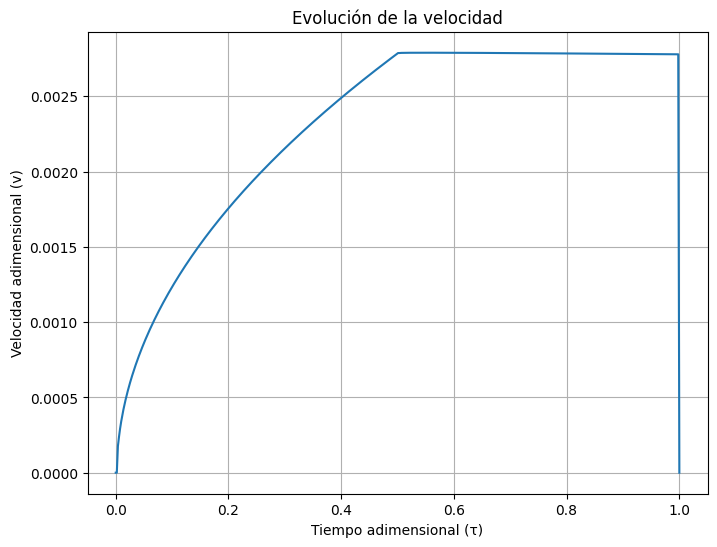

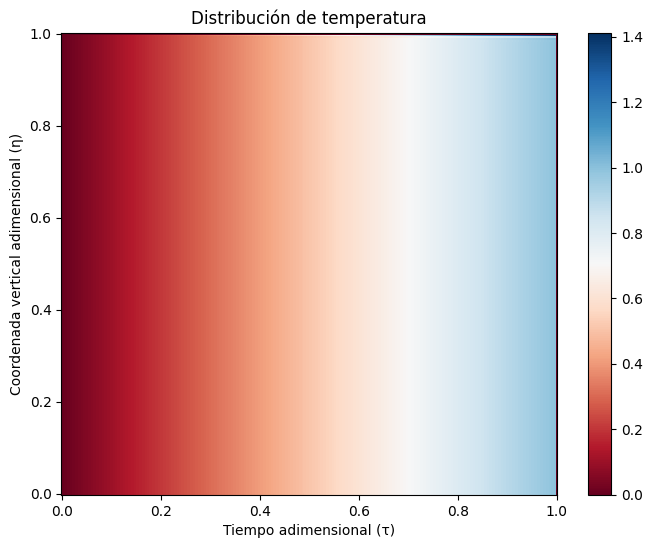

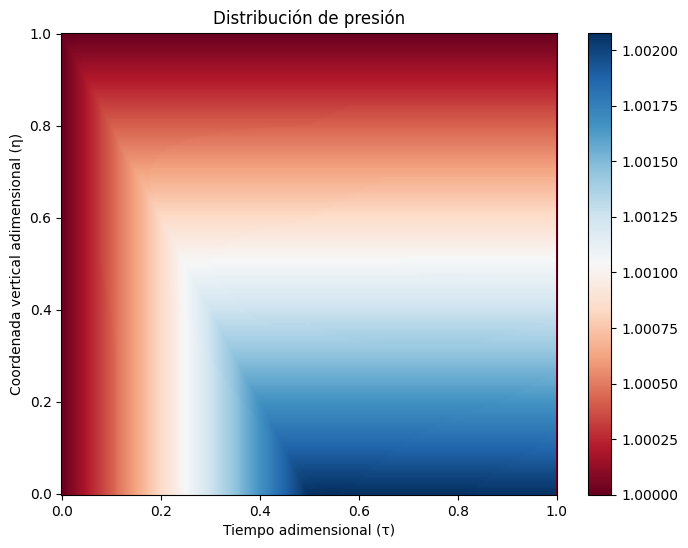

In [8]:
print(Pi)

# Gráfico lineal de v
plt.figure(figsize=(8, 6))
plt.plot(tau, v)
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Velocidad adimensional (v)')
plt.title('Evolución de la velocidad')
plt.grid()
plt.show()

# Mapa de calor de θ
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, theta, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de temperatura')
plt.show()

# Mapa de calor de Π
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, Pi, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de presión')
plt.show()

## Presiones truchas

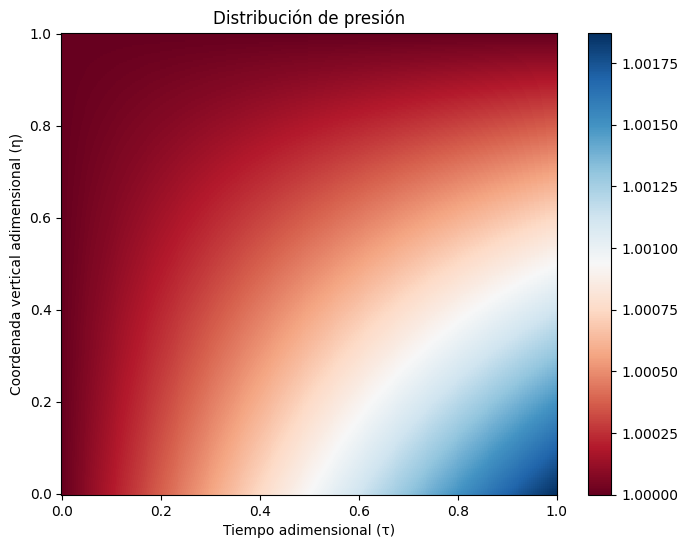

In [9]:
Pi_max = p_e/p_atm
ult_col = np.linspace( Pi_max, 1, M)
Pi_trucha = np.ones((M, N))
for i in range(M-1):
    Pi_trucha[i, :] = np.linspace(1, ult_col[i], N)

# Mapa de calor de Π
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, Pi_trucha, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de presión')
plt.show()



In [10]:
# Definición de variables y condiciones iniciales
M = 256 # Número de puntos en la dirección vertical
N = 512 # Número de puntos en la dirección temporal
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/M
dtau = (tau[-1] - tau[0])/N 
v = np.zeros(N)  # Velocidad adimensional
theta = np.zeros((M, N))  # Temperatura adimensional

# Condiciones iniciales
v[0] = 0.0  # Velocidad inicial cero
theta[:, 0] = 0.0  # Temperatura inicial uniforme

# Simulación numérica
for t in range(1, N-1):

    # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
    v[t] = np.sqrt((Pi_trucha[0, t-1] - p_0) * Pi_d)

    # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
    for x in range(M-1):
         
        dtheta_deta = (theta[x+1, t-1] - theta[x, t-1]) / deta
        d2theta_deta2 = (theta[x+1, t-1] - 2 * theta[x, t-1] + theta[x-1, t-1]) / deta**2
        theta[x, t] = theta[x, t-1] + dtau * (- psi * v[t] * dtheta_deta
                                            + delta * d2theta_deta2
                                            - gamma_prima * (theta[x, t-1] - theta_r))

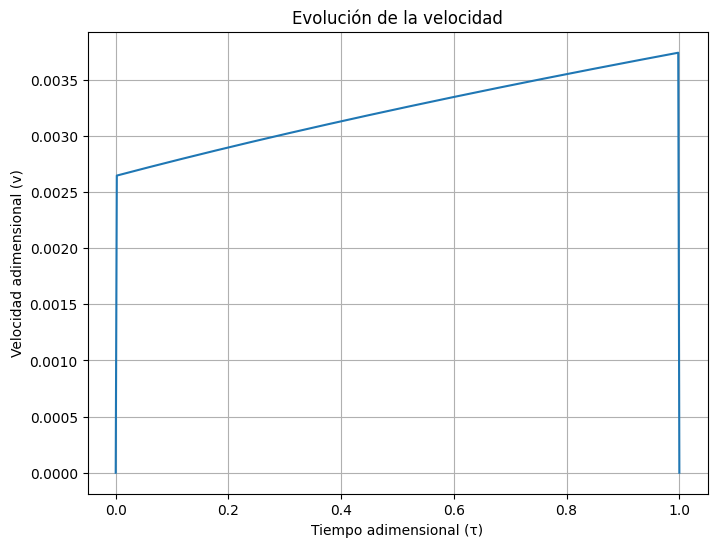

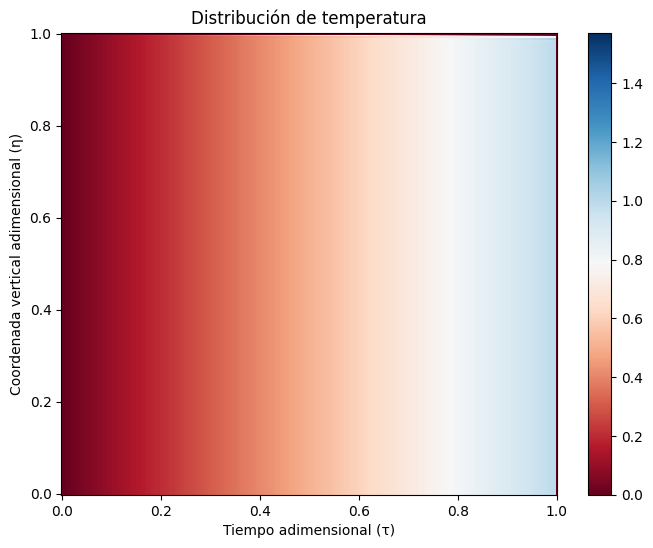

In [11]:
# Gráfico lineal de v
plt.figure(figsize=(8, 6))
plt.plot(tau, v)
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Velocidad adimensional (v)')
plt.title('Evolución de la velocidad')
plt.grid()
plt.show()

# Mapa de calor de θ
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, theta, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de temperatura')
plt.show()


## Modelo 2

In [12]:
# Definición de variables y condiciones iniciales
M = 256 # Número de puntos en la dirección vertical
N = 512 # Número de puntos en la dirección temporal
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/M
dtau = (tau[-1] - tau[0])/N 
v = np.zeros(N)  # Velocidad adimensional
theta = np.zeros((M, N))  # Temperatura adimensional

# Condiciones iniciales
v[0] = 0.0  # Velocidad inicial cero
theta[:, 0] = 0.0  # Temperatura inicial uniforme

# Simulación numérica
for t in range(1, N-1):

    # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
    v[t] = np.sqrt((Pi_trucha[0, t-1] - p_0) * Pi_d)

    # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
    for x in range(M-1):
         
        dtheta_deta = (theta[x+1, t-1] - theta[x, t-1]) / deta
        d2theta_deta2 = (theta[x+1, t-1] - 2 * theta[x, t-1] + theta[x-1, t-1]) / deta**2
        theta[x, t] = theta[x, t-1] + dtau * (- psi * v[t] * dtheta_deta
                                            + delta * d2theta_deta2
                                            - gamma_prima * (theta[x, t-1] - theta_r))